# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

원본 데이터: 2240행 × 29열
Income 결측치: 24개


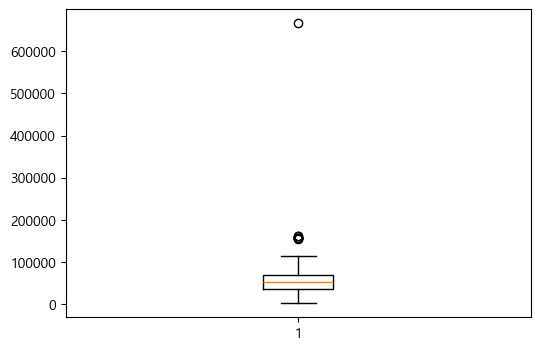

→ Income 중앙값(51,382)으로 대치 완료
35538.75 68289.75 -13587.75 117416.25
164     157243.0
617     162397.0
655     153924.0
687     160803.0
1300    157733.0
1653    157146.0
2132    156924.0
2233    666666.0
Name: Income, dtype: float64


In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")
Income_series = df['Income']
Income_min = df['Income'].min()
Income_max = df['Income'].max()
fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot(Income_series.dropna())
plt.show()

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

Income_series = df['Income']
Q1 = np.quantile(Income_series,0.25)
Q3 = np.quantile(Income_series,0.75)
IQR = Q3 - Q1
lower_range = Q1 - 1.5*IQR
higher_range = Q3 + 1.5*IQR
outliers = (Income_series < lower_range) | (Income_series> higher_range)
print(Q1, Q3, lower_range, higher_range)
print(Income_series[outliers])

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   str    
 3   Marital_Status       2240 non-null   str    
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   str    
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   int64  
 16 

### 0-2. 파생변수 생성

In [4]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [5]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


In [6]:
df_copy= df.copy()

---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [7]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
for i in ['Income', 'Total_Spending', 'Age']:
    print(f"{i}// mean: {df[i].mean()}, median: {df[i].median()}, mode: {df[i].mode()[0]}, 5% trim_mean: {stats.trim_mean(df[i],0.05)}")

Income// mean: 51952.61404293381, median: 51381.5, mode: 51381.5, 5% trim_mean: 51740.153426017874
Total_Spending// mean: 605.9865831842576, median: 396.5, mode: 46, 5% trim_mean: 561.1196623634559
Age// mean: 55.10196779964222, median: 54.0, mode: 48, 5% trim_mean: 55.074975173783514


In [8]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
for i in ['Income', 'Total_Spending', 'Age']:
    print(f"{i}// var: {np.var(df[i],ddof=1)}, std: {np.std(df[i],ddof=1)}, IQR: {np.quantile(df[i],0.75)-np.quantile(df[i],0.25)}, CV: {np.std(df[i],ddof=1)/df[i].mean()*100}")

Income// var: 458450912.69258124, std: 21411.466850558867, IQR: 32773.25, CV: 41.21345430831326
Total_Spending// var: 362241.6660391478, std: 601.8651560267863, IQR: 976.5, CV: 99.31988145087065
Age// var: 136.96677912379488, std: 11.70328069917982, IQR: 18.0, CV: 21.239315339398477


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

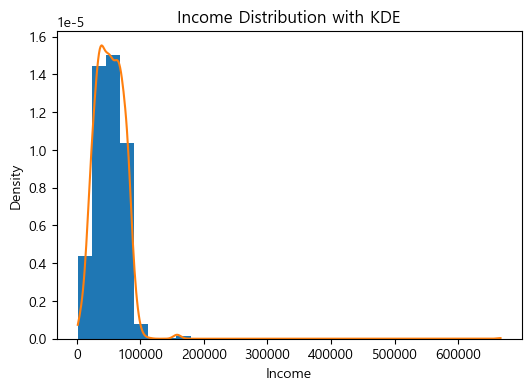

In [9]:
# TODO 1-2(a): Income 히스토그램 + KDE
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize=(6,4))

# Income_series: Pandas Series

# 히스토그램
ax.hist(Income_series, bins=30, density=True)

# KDE 계산
kde = gaussian_kde(Income_series)
x = np.linspace(Income_series.min(), Income_series.max(), 500)
ax.plot(x, kde(x))

ax.set_title("Income Distribution with KDE")
ax.set_xlabel("Income")
ax.set_ylabel("Density")

plt.show()

69.0 1045.5 -1395.75 2510.25
1179    2525
1492    2524
1572    2525
Name: Total_Spending, dtype: int64


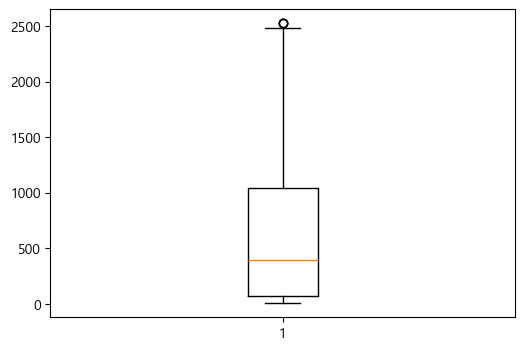

In [10]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치

Income_series = df['Total_Spending']
Q1 = np.quantile(Income_series,0.25)
Q3 = np.quantile(Income_series,0.75)
IQR = Q3 - Q1
lower_range = Q1 - 1.5*IQR
higher_range = Q3 + 1.5*IQR
outliers = (Income_series < lower_range) | (Income_series> higher_range)
print(Q1, Q3, lower_range, higher_range)
print(Income_series[outliers])

fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot(Income_series)
plt.show()

In [11]:
df_copy.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
       'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
       'Marital_Group', 'Campaign_Response', 'Customer_Days'],
      dtype='str')

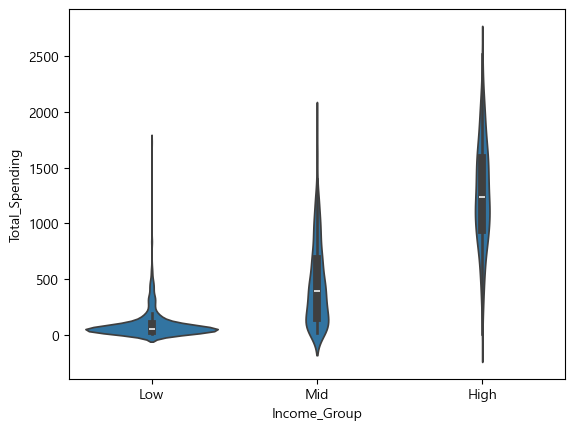

In [12]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
import seaborn as sns
sns.violinplot(x='Income_Group', y='Total_Spending', data=df_copy)
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [13]:
df_copy.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
       'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
       'Marital_Group', 'Campaign_Response', 'Customer_Days'],
      dtype='str')

In [14]:
spending_names = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
for col in spending_names:
    series = df_copy[col].dropna()
    
    skew_val = series.skew()
    kurt_val = series.kurt()
    
    print(f"{col}")
    print(f"왜도 (Skewness): {skew_val:.3f}")
    print(f"첨도 (Kurtosis): {kurt_val:.3f}\n")

MntWines
왜도 (Skewness): 1.176
첨도 (Kurtosis): 0.601

MntFruits
왜도 (Skewness): 2.104
첨도 (Kurtosis): 4.070

MntMeatProducts
왜도 (Skewness): 2.085
첨도 (Kurtosis): 5.530

MntFishProducts
왜도 (Skewness): 1.920
첨도 (Kurtosis): 3.096

MntSweetProducts
왜도 (Skewness): 2.136
첨도 (Kurtosis): 4.372

MntGoldProds
왜도 (Skewness): 1.885
첨도 (Kurtosis): 3.558



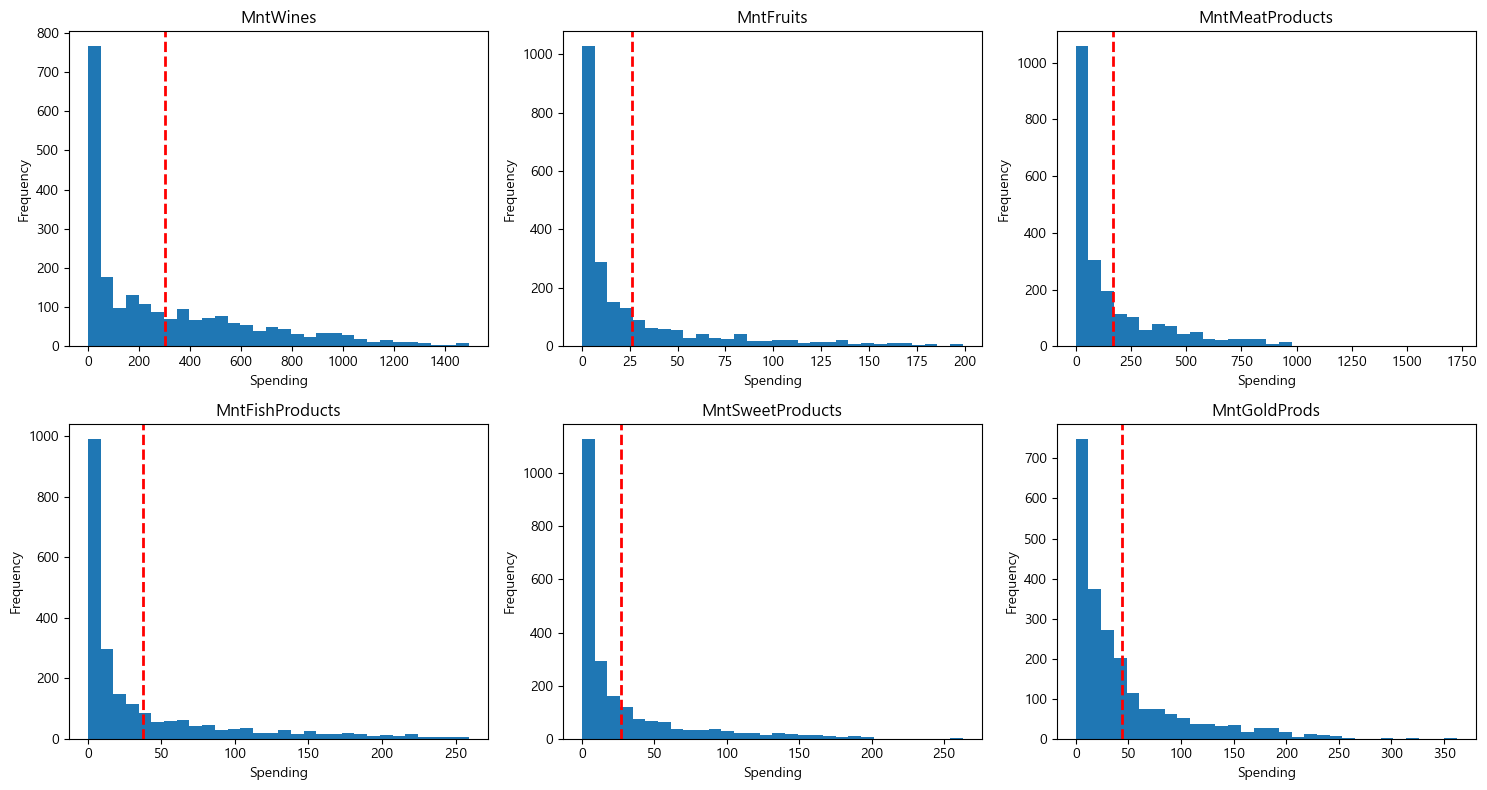

In [15]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(spending_names):
    data = df_copy[col].dropna()
    
    ax = axes[i]
    ax.hist(data, bins=30)
    
    mean_val = data.mean()
    ax.axvline(
    mean_val,
    color='red',     
    linestyle='--',   
    linewidth=2
)
    
    ax.set_title(col)
    ax.set_xlabel("Spending")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [16]:
# TODO 1-4: 비즈니스 인사이트 정리
print(f"소득은 평균, 중간값, 절사평균의 차이가 별로 없어서 안정적인 중심을 가졌다고 볼 수 있다. 다만, CV가 높은 것으로 보아 평균 대비 변동성이 커 고객 간 소득 수준의 격차가 존재한다고 해석할 수 있다.")
print(f"총소비는 평균이 중간값보다 높은 것을 볼 수 있고 최빈값이 낮은것으로 보아, 일부 고소비 고객이 평균을 끌어올리는 구조로 보인다. 다만, CV가 높은 것으로 보아 변동성이 높을 것으로 예상해 볼 수 있을 것이다.")
print(f"연령은 평균, 중간값, 절사평균의 차이가 별로 없어서 안정적인 중심을 가졌다고 볼 수 있다. 또한 CV가 낮아서 집단 내 동질성이 높은 변수로 보인다.\n")

print(f"소수의 고객이 극단적인 매출을 내고 있음을 볼 수 있다. 카테고리 소비에서도 첨도를 통해 일정 고객이 특정카테고리에 집중 소비하는 것 예상할 수 있다. 데이터들에 왜도가 큰 경우들이 많아서 평균을 통한 해석 자체가 위험할 수 있음.\n")

print("1. 소득과 총소비 간 유의한 상관관계가 있을 것이다.")
print("2. 소득 그룹 간 평균 총소비에는 유의미한 차이가 존재할 것이다.")
print("3. 연령은 총소비를 유의하게 설명하지 못할 것이다.")

소득은 평균, 중간값, 절사평균의 차이가 별로 없어서 안정적인 중심을 가졌다고 볼 수 있다. 다만, CV가 높은 것으로 보아 평균 대비 변동성이 커 고객 간 소득 수준의 격차가 존재한다고 해석할 수 있다.
총소비는 평균이 중간값보다 높은 것을 볼 수 있고 최빈값이 낮은것으로 보아, 일부 고소비 고객이 평균을 끌어올리는 구조로 보인다. 다만, CV가 높은 것으로 보아 변동성이 높을 것으로 예상해 볼 수 있을 것이다.
연령은 평균, 중간값, 절사평균의 차이가 별로 없어서 안정적인 중심을 가졌다고 볼 수 있다. 또한 CV가 낮아서 집단 내 동질성이 높은 변수로 보인다.

소수의 고객이 극단적인 매출을 내고 있음을 볼 수 있다. 카테고리 소비에서도 첨도를 통해 일정 고객이 특정카테고리에 집중 소비하는 것 예상할 수 있다. 데이터들에 왜도가 큰 경우들이 많아서 평균을 통한 해석 자체가 위험할 수 있음.

1. 소득과 총소비 간 유의한 상관관계가 있을 것이다.
2. 소득 그룹 간 평균 총소비에는 유의미한 차이가 존재할 것이다.
3. 연령은 총소비를 유의하게 설명하지 못할 것이다.


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [17]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10
p = df_copy['Response'].mean()
binom_dist = stats.binom(10, p)
a = binom_dist.pmf(2)
b = binom_dist.sf(2)
print(a,b)

0.27521465499368963 0.17818029736723678


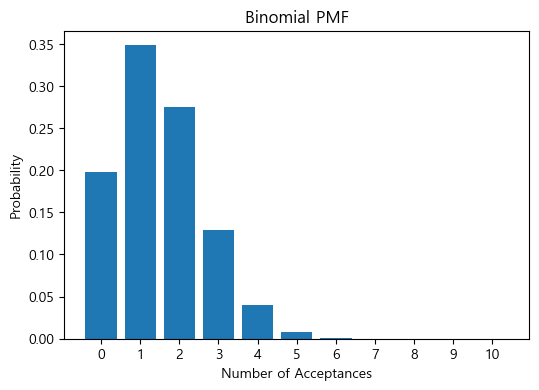

In [18]:
# TODO 2-1(c): 이항분포 PMF 시각화
x = np.arange(0, n_trial + 1)
pmf_vals = binom_dist.pmf(x)

plt.figure(figsize=(6,4))
plt.bar(x, pmf_vals)

plt.title(f"Binomial PMF")
plt.xlabel("Number of Acceptances")
plt.ylabel("Probability")
plt.xticks(x)

plt.show()

In [19]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100
binom_100 = stats.binom(n_campaign, p)

expected = n_campaign * p

p_ge_15 = binom_100.sf(14)

k_90 = int(binom_100.ppf(0.90))

print(f"n=100, p={p:.6f}")
print(f"E(X) = {expected:.4f}")
print(f"P(X >= 15) = {p_ge_15:.6f}")
print(f"k = {k_90}")

n=100, p=0.149374
E(X) = 14.9374
P(X >= 15) = 0.535806
k = 20


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [20]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lambda_visit = web_visits.mean()
var_visit = web_visits.var(ddof=1)
print(f"평균-분산 차이: {abs(lambda_visit - var_visit):.4f}")
print("포아송 가정을 크게 위반한다고 보기는 어려움")

평균-분산 차이: 0.5709
포아송 가정을 크게 위반한다고 보기는 어려움


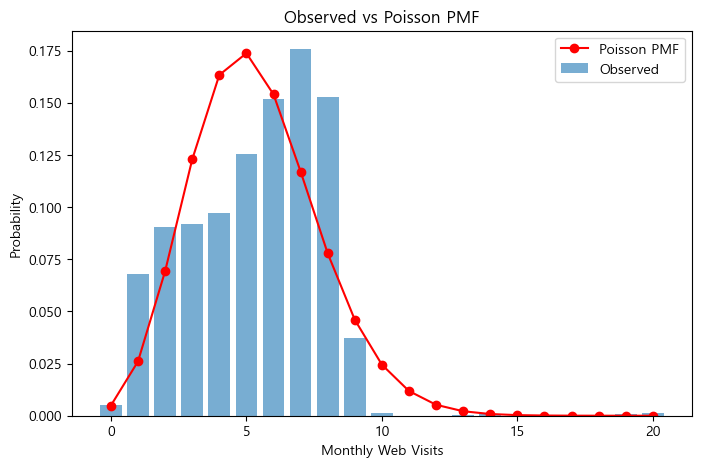

In [21]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
web_visits = df['NumWebVisitsMonth']
lambda_visit = web_visits.mean()

x_vals = np.arange(0, web_visits.max() + 1)
observed_probs = web_visits.value_counts(normalize=True).sort_index()

poisson_probs = stats.poisson.pmf(x_vals, lambda_visit)

plt.figure(figsize=(8,5))

plt.bar(observed_probs.index, observed_probs.values,
        alpha=0.6, label='Observed')
plt.plot(x_vals, poisson_probs, 'r-o', label='Poisson PMF')

plt.xlabel("Monthly Web Visits")
plt.ylabel("Probability")
plt.title(f"Observed vs Poisson PMF")
plt.legend()

plt.show()

In [22]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10
p_10 = stats.poisson.sf(heavy_threshold - 1, lambda_visit)
k_95 = int(stats.poisson.ppf(0.95, lambda_visit))
print(f"평균 방문수: {lambda_visit:.4f}")
print(f"P(X ≥ 10): {p_10:.6f}")
print(f"최소 k: {k_95}")

평균 방문수: 5.3189
P(X ≥ 10): 0.044919
최소 k: 9


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [23]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교
income = df_copy["Income"] 
mu = income.mean()
sigma = income.std(ddof=0)
dist = stats.norm(loc=mu, scale=sigma)
p_lt_30000_theory = dist.cdf(30000)
p_gt_80000_theory = dist.sf(80000) 
top10_cut_theory  = dist.ppf(0.90) 

p_lt_30000_emp = (income < 30000).mean()
p_gt_80000_emp = (income > 80000).mean()
top10_cut_emp  = income.quantile(0.90)

print("[P(Income < 30000)]")
print(f"  이론: {p_lt_30000_theory:.4f}")
print(f"  실측: {p_lt_30000_emp:.4f}")
print(f"  차이(실측-이론): {(p_lt_30000_emp - p_lt_30000_theory):.4f}\n")

print("[P(Income > 80000)]")
print(f"  이론: {p_gt_80000_theory:.4f}")
print(f"  실측: {p_gt_80000_emp:.4f}")
print(f"  차이(실측-이론): {(p_gt_80000_emp - p_gt_80000_theory):.4f}\n")

print("[상위 10% 소득 기준값]")
print(f"  이론 90%: {top10_cut_theory:.2f}")
print(f"  실측 90%: {top10_cut_emp:.2f}")
print(f"  차이(실측-이론): {(top10_cut_emp - top10_cut_theory):.2f}")

[P(Income < 30000)]
  이론: 0.1526
  실측: 0.1655
  차이(실측-이론): 0.0129

[P(Income > 80000)]
  이론: 0.0951
  실측: 0.0962
  차이(실측-이론): 0.0011

[상위 10% 소득 기준값]
  이론 90%: 79386.38
  실측 90%: 79747.50
  차이(실측-이론): 361.12


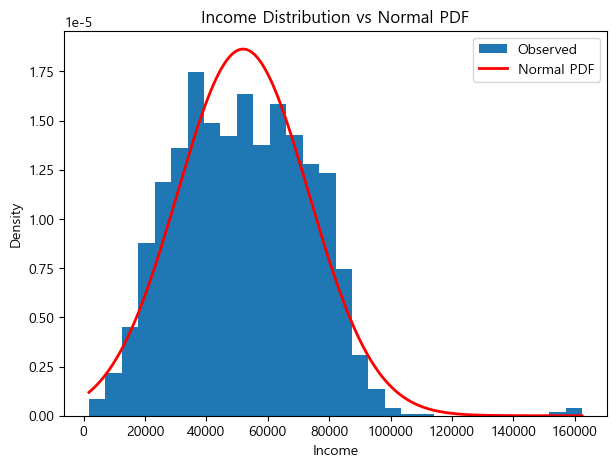

In [24]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
mu = income.mean()
sigma = income.std(ddof=0)
x = np.linspace(income.min(), income.max(), 500)
plt.figure(figsize=(7,5))
plt.hist(income, bins=30, density=True, label='Observed')
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal PDF')

plt.title(f"Income Distribution vs Normal PDF")
plt.xlabel("Income")
plt.ylabel("Density")
plt.legend()

plt.show()

In [25]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
income = df_copy["Income"]
mu = income.mean()
sigma = income.std(ddof=0)

dist = stats.norm(loc=mu, scale=sigma)
vip_cutoff = dist.ppf(0.95)
discount_cutoff = dist.ppf(0.10)

print(f"mu = {mu:.2f}, sigma = {sigma:.2f}\n")

print(f"VIP(상위 5%) 기준선: {vip_cutoff:.2f}")
print(f"할인 대상(하위 10%) 기준선: {discount_cutoff:.2f}")

mu = 51952.61, sigma = 21406.68

VIP(상위 5%) 기준선: 87163.47
할인 대상(하위 10%) 기준선: 24518.85


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [26]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE
x = df_copy["Total_Spending"]

n = len(x)
xbar = x.mean()
s = x.std(ddof=1)
se = s / np.sqrt(n)

levels = [0.90, 0.95, 0.99]

for conf in levels:
    alpha = 1 - conf
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)  # t_(alpha/2, n-1)
    margin = t_crit * se
    ci_low, ci_high = xbar - margin, xbar + margin
    
    print(f"{int(conf*100)}% CI: [{ci_low:.4f}, {ci_high:.4f}] (t*={t_crit:.4f})")

90% CI: [585.0421, 626.9311] (t*=1.6455)
95% CI: [581.0265, 630.9467] (t*=1.9610)
99% CI: [573.1732, 638.8000] (t*=2.5780)


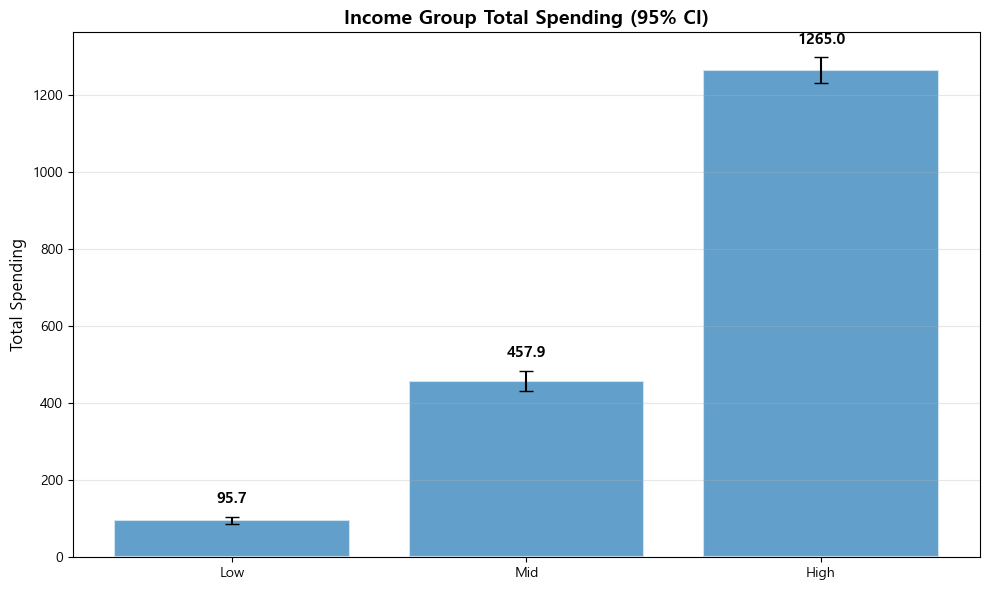

In [27]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
group_col = "Income_Group"
target_col = "Total_Spending"

group_order = list(df_copy[group_col].cat.categories) if hasattr(df_copy[group_col].dtype, "categories") else ["Low","Mid","High"]
group_data = {str(g): df_copy.loc[df_copy[group_col] == g, target_col].dropna() for g in group_order}

means = []
margins = []  # 95% CI half-width

for d in group_data.values():
    n = len(d)
    mean = d.mean()
    se = d.std(ddof=1) / np.sqrt(n)
    t_crit = stats.t.ppf(0.975, df=n-1)
    margin = t_crit * se
    means.append(mean)
    margins.append(margin)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(
    group_data.keys(), means, yerr=margins, capsize=5,
    alpha=0.7, edgecolor='white', linewidth=1.5
)

for bar, mean, m in zip(bars, means, margins):
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        mean + m + (0.02 * max(means)),
        f'{mean:.1f}',
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

ax.set_ylabel('Total Spending', fontsize=12)
ax.set_title('Income Group Total Spending (95% CI)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [28]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)
mean1, mean2 = no_child.mean(), yes_child.mean()
std1, std2 = no_child.std(ddof=1), yes_child.std(ddof=1)
pooled_std = np.sqrt((std1**2 + std2**2) / 2)
cohen_d = (mean1 - mean2) / pooled_std
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p_value:.6f}\n")

print(f"효과크기 = {cohen_d:.4f}")

t-statistic = 24.9889
p-value = 0.000000

효과크기 = 1.2547


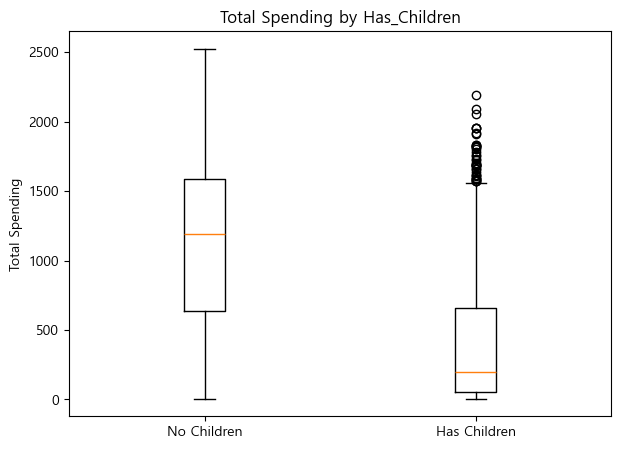

In [29]:
# TODO 3-2(c): 박스플롯 비교 시각화
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

plt.figure(figsize=(7,5))

plt.boxplot([no_child, yes_child],
            labels=['No Children', 'Has Children'])

plt.ylabel("Total Spending")
plt.title("Total Spending by Has_Children")
plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [30]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
diff = wines - meat
t_stat, p_value = stats.ttest_rel(wines, meat)
mean_diff = diff.mean()
std_diff = diff.std(ddof=1)
cohen_d = mean_diff / std_diff
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p_value}\n")
print(f"효과크기 = {cohen_d:.4f}")

t-statistic = 23.0929
p-value = 5.391926544698085e-106

효과크기 = 0.4884


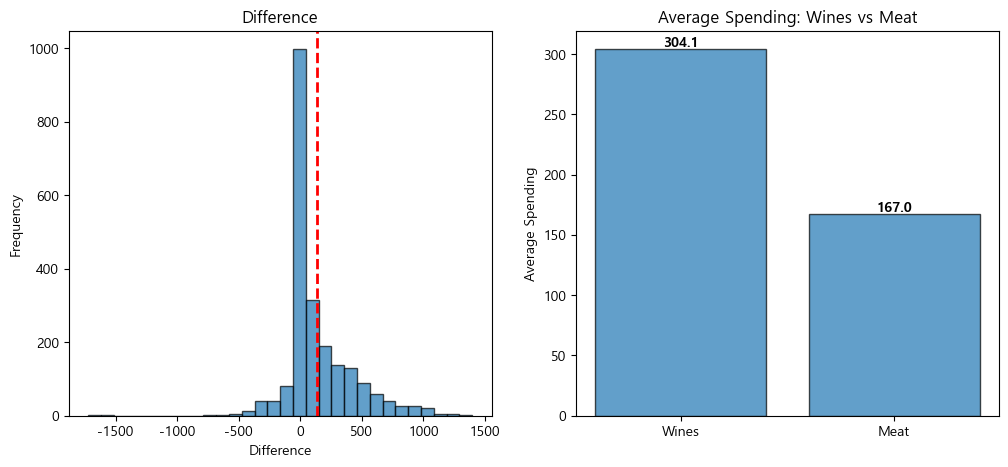

In [31]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].hist(diff, bins=30, edgecolor='black', alpha=0.7)

axes[0].axvline(diff.mean(), color='red', linestyle='--', linewidth=2)

axes[0].set_title("Difference")
axes[0].set_xlabel("Difference")
axes[0].set_ylabel("Frequency")

means = [wines.mean(), meat.mean()]
labels = ['Wines', 'Meat']
bars = axes[1].bar(labels, means, alpha=0.7, edgecolor='black')

for bar, mean in zip(bars, means):
    axes[1].text(
        bar.get_x() + bar.get_width()/2,
        mean,
        f'{mean:.1f}',
        ha='center',
        va='bottom',
        fontweight='bold'
    )
axes[1].set_ylabel("Average Spending")
axes[1].set_title("Average Spending: Wines vs Meat")

plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [32]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
effect_size = cohen_d
n1 = len(no_child)
n2 = len(yes_child)
power = power_analysis.power(
    effect_size=abs(effect_size),
    nobs1=n1,
    ratio=n2/n1,
    alpha=0.05
)
print(f"Power = {power}")

# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
required_n = power_analysis.solve_power(
    effect_size=0.2,
    power=0.8,
    alpha=0.05,
    ratio=1.0
)
print(f"Required n = {required_n:.0f}")

Power = 1.0
Required n = 393


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [33]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
for g in edu_groups:
    data = df_copy[df_copy['Education_Group'] == g]['Total_Spending'].dropna()
    n = len(data)
    
    print(f"\n[{g}]")
    print(f"표본 크기 n = {n}")
    
    stat, p = stats.shapiro(data)
    print(f"Shapiro-Wilk p-value = {p}")
    
    if p < 0.05:
        print("정규성 기각")
    else:
        print("정규성 가정 충족")
    

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
group_data = [
    df[df['Education_Group'] == g]['Total_Spending'].dropna()
    for g in edu_groups
]

stat, p_levene = stats.levene(*group_data)
if p_levene < 0.05:
    print(" → 등분산 가정 기각 Welch ANOVA 사용")
    use_welch = True
else:
    print(" → 등분산 가정 충족 일반 ANOVA 사용")
    use_welch = False
print(f"\nuse_welch = {use_welch}")


[Undergraduate]
표본 크기 n = 255
Shapiro-Wilk p-value = 5.543648052614619e-19
정규성 기각

[Graduate]
표본 크기 n = 1126
Shapiro-Wilk p-value = 3.561909628976696e-29
정규성 기각

[Postgraduate]
표본 크기 n = 855
Shapiro-Wilk p-value = 1.7757879312718283e-25
정규성 기각
 → 등분산 가정 기각 Welch ANOVA 사용

use_welch = True


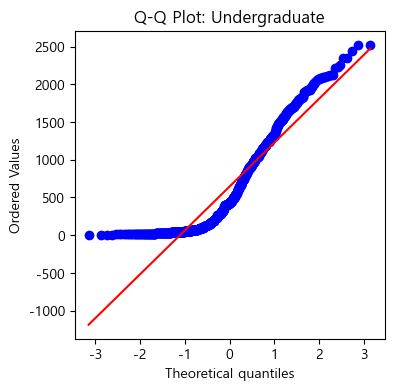

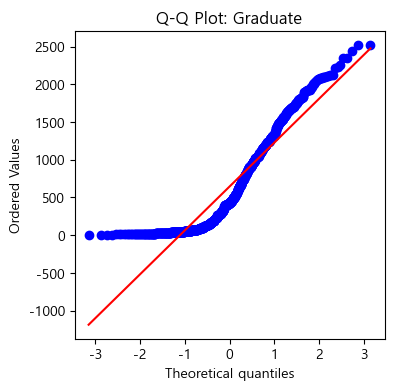

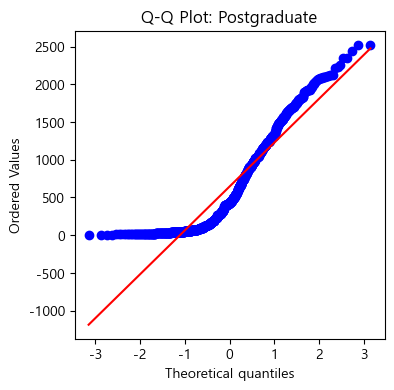

In [34]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)
for g in edu_groups:
    plt.figure(figsize=(4,4))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot: {g}")
    plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [35]:
from statsmodels.stats.oneway import anova_oneway
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
groups = list(group_data.values())
k = len(groups)
n_total = sum(len(g) for g in groups)
welch = anova_oneway(groups, use_var='unequal')
print("Welch ANOVA")

F_stat = welch.statistic
p_value = welch.pvalue
print(f"H = {F_stat:.4f}, p = {p_value}")

H_stat, p_kw = stats.kruskal(*groups)
print("\nKruskal-Wallis")
print(f"H = {H_stat:.4f}, p = {p_kw}")

# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
grand_mean = np.mean(np.concatenate(groups))
SS_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
SS_within = sum(sum((g - np.mean(g))**2) for g in groups)
SS_total = SS_between + SS_within
df_between = k - 1
df_within = n_total - k
MS_within = SS_within / df_within
eta_squared = SS_between / SS_total
omega_squared = (SS_between - df_between * MS_within) / (SS_total + MS_within)

print("\nEffect Size")
print(f"η² = {eta_squared:.4f}")
print(f"ω² = {omega_squared:.4f}")


Welch ANOVA
H = 19.8174, p = 4.098695866028927e-09

Kruskal-Wallis
H = 36.6133, p = 1.1207736037427136e-08

Effect Size
η² = 0.0137
ω² = 0.0128


In [36]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g
import pingouin as pg

print("=== Games-Howell 사후검정 ===")
    
gh = pg.pairwise_gameshowell(
    data=df_copy,
    dv='Total_Spending',
    between='Education_Group'
    )

display(gh[['A','B','pval','hedges']])

=== Games-Howell 사후검정 ===


,A,B,pval,hedges
0,Graduate,Postgraduate,6.523632e-01,-0.040121
1,Graduate,Undergraduate,8.920656e-08,0.355688
2,Postgraduate,Undergraduate,9.577128e-09,0.389636


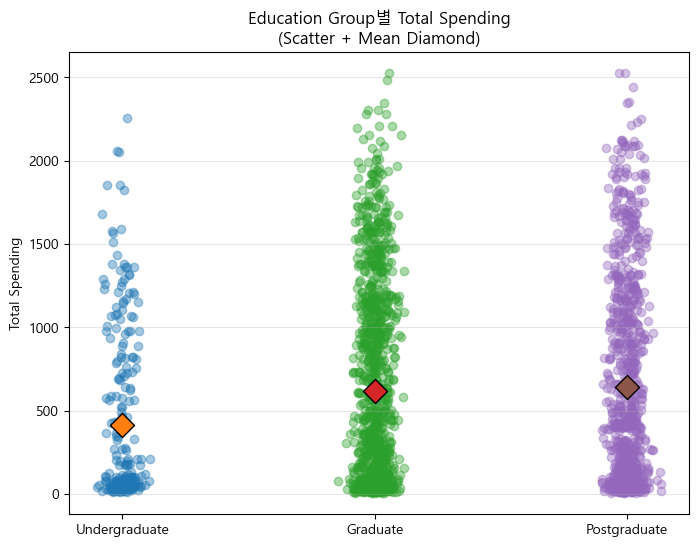

In [37]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
group_col = 'Education_Group'
target_col = 'Total_Spending'

groups = edu_groups
plt.figure(figsize=(8,6))

for i, g in enumerate(groups):
    data = df_copy[df_copy[group_col] == g][target_col].dropna()
    
    x_jitter = np.random.normal(i, 0.04, size=len(data))
    plt.scatter(x_jitter, data, alpha=0.4)
    
    mean_val = data.mean()
    plt.scatter(i, mean_val,
                marker='D', s=150,
                edgecolor='black',
                zorder=5)
    
plt.xticks(range(len(groups)), groups)
plt.ylabel("Total Spending")
plt.title("Education Group별 Total Spending\n(Scatter + Mean Diamond)")

plt.grid(axis='y', alpha=0.3)
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [38]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
table_np: np.ndarray = np.asarray(crosstab_no_margin, dtype=float)
chi2, p, dof, expected_raw = stats.chi2_contingency(table_np, correction=False)
expected: np.ndarray = np.asarray(expected_raw, dtype=float)

# ── Cochran's rule(카이제곱 근사 조건) 확인 ──
n_under1 = np.sum(expected < 1)
pct_under5 = np.mean(expected < 5)
cochran_ok = (n_under1 == 0) and (pct_under5 <= 0.20)

print("shape =", table_np.shape)
print("n_under1 =", int(n_under1))
print("pct_under5 =", float(pct_under5))
print("cochran_ok =", bool(cochran_ok))

alpha = 0.05 
table_np = np.asarray(crosstab_no_margin, dtype=float)

chi2, p, dof, expected_raw = stats.chi2_contingency(table_np, correction=False)
expected = np.asarray(expected_raw, dtype=float)

print("[카이제곱 독립성 검정]")
print(f"  chi2 = {chi2:.4f}, dof = {dof}, p = {p:.4g}, alpha = {alpha}")

if p < alpha:
    print("  귀무가설 기각: 두 범주형 변수는 독립이 아닐 가능성이 있습니다(연관성 존재).")
else:
    print("  귀무가설 기각 실패: 연관성에 대한 통계적 증거가 부족합니다.")
    print("  (주의) 표본이 작으면 검정력이 낮아 p가 커질 수 있으니, 효과크기도 함께 보세요.")

# TODO 4-3(b): φ (phi) 계산
n = table_np.sum()
phi = np.sqrt(chi2 / n)

print("\n[효과크기: Phi]")
print(f"  φ = {phi:.4f}")

# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
a, b, c, d = table_np.flatten()

odds_ratio = (a * d) / (b * c)
se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
log_or = np.log(odds_ratio)

z = 1.96
ci_low = np.exp(log_or - z * se_log_or)
ci_high = np.exp(log_or + z * se_log_or)

print("\n[오즈비 분석]")
print(f"Odds Ratio = {odds_ratio:.4f}")
print(f"95% CI = ({ci_low:.4f}, {ci_high:.4f})")

shape = (2, 2)
n_under1 = 0
pct_under5 = 0.0
cochran_ok = True
[카이제곱 독립성 검정]
  chi2 = 9.5411, dof = 1, p = 0.002009, alpha = 0.05
  귀무가설 기각: 두 범주형 변수는 독립이 아닐 가능성이 있습니다(연관성 존재).

[효과크기: Phi]
  φ = 0.0653

[오즈비 분석]
Odds Ratio = 0.7396
95% CI = (0.6105, 0.8959)


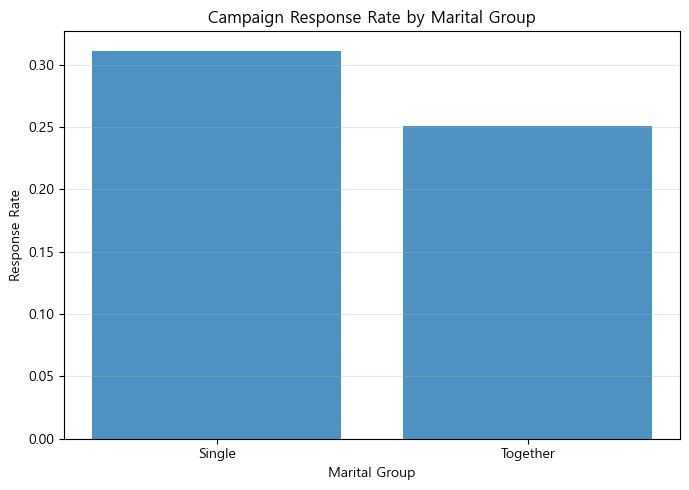

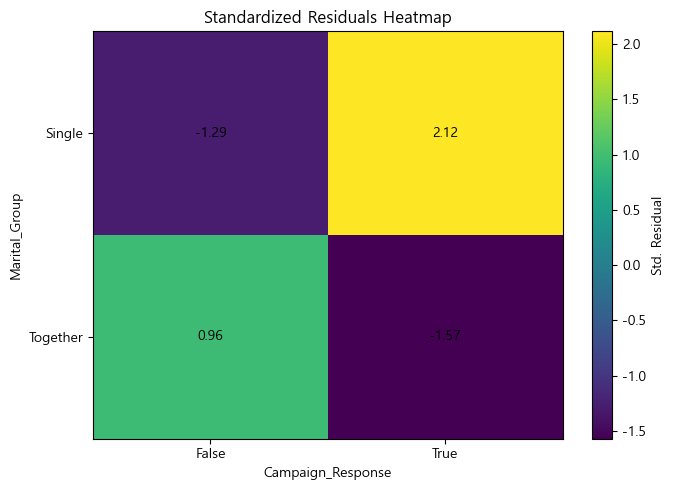

In [39]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵
if True in crosstab_no_margin.columns:
    resp_col = True
elif 1 in crosstab_no_margin.columns:
    resp_col = 1
else:
    resp_col = crosstab_no_margin.columns[-1]
response_rate = crosstab_no_margin[resp_col] / crosstab_no_margin.sum(axis=1)

plt.figure(figsize=(7,5))
plt.bar(response_rate.index.astype(str), response_rate.values, alpha=0.8)

plt.ylabel("Response Rate")
plt.xlabel("Marital Group")
plt.title("Campaign Response Rate by Marital Group")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

O = table_np
E = expected
std_resid = (O - E) / np.sqrt(E)
fig, ax = plt.subplots(figsize=(7,5))
im = ax.imshow(std_resid, aspect='auto')
ax.set_xticks(range(crosstab_no_margin.shape[1]))
ax.set_xticklabels([str(c) for c in crosstab_no_margin.columns])
ax.set_yticks(range(crosstab_no_margin.shape[0]))
ax.set_yticklabels([str(r) for r in crosstab_no_margin.index])

ax.set_title("Standardized Residuals Heatmap")
ax.set_xlabel("Campaign_Response")
ax.set_ylabel("Marital_Group")
for i in range(std_resid.shape[0]):
    for j in range(std_resid.shape[1]):
        ax.text(j, i, f"{std_resid[i, j]:.2f}", ha='center', va='center')

plt.colorbar(im, ax=ax, label="Std. Residual")
plt.tight_layout()
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [ ]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values
total = observed.sum()
expected = np.full(3, total / 3)

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
expected = np.asarray(expected, dtype=float)
n_under1 = np.sum(expected < 1)
pct_under5 = np.mean(expected < 5)
cochran_ok = (n_under1 == 0) and (pct_under5 <= 0.20)

print("n_under1 =", int(n_under1))
print("pct_under5 =", float(pct_under5))
print("cochran_ok =", bool(cochran_ok))


n_under1 = 0
pct_under5 = 0.0
cochran_ok = True


In [50]:
observed = np.asarray(observed, dtype=float)
expected = np.asarray(expected, dtype=float)
n = float(observed.sum())

chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)
df = int(len(observed) - 1)

print("[카이제곱 적합도 검정]")
print(f"  chi2 = {chi2:.4f}, df = {df}, p = {p:.4g}, alpha = {alpha}")

if p < alpha:
    print("귀무가설 기각: 관측 분포가 기대 분포와 다르다는 증거가 있습니다.")
else:
    print("귀무가설 기각 실패: 기대 분포와 다르다는 증거가 부족합니다.")
    print("(주의) 표본이 작으면 검정력이 낮아 p가 커질 수 있습니다. 효과크기/잔차도 함께 보세요.")

[카이제곱 적합도 검정]
  chi2 = 2630.1063, df = 2, p = 0, alpha = 0.05
귀무가설 기각: 관측 분포가 기대 분포와 다르다는 증거가 있습니다.


In [51]:
# 효과크기: Cohen's w
w = float(np.sqrt(chi2 / n)) if n > 0 else float("nan")
print(f"  효과크기 Cohen's w = {w:.4f}")
print("    (참고 기준) w≈0.10(작음), 0.30(중간), 0.50(큼 — 맥락 의존)")

# 사후분석: 표준화 잔차
std_residuals = (observed - expected) / np.sqrt(expected)
print("[사후분석] 표준화 잔차 (|z|>2이면 기대와 다른 범주일 수 있음)")
for i, z in enumerate(std_residuals):
    flag = " |z|>2" if np.isfinite(z) and abs(z) > 2 else ""
    print(f"  category[{i}] z = {float(z):.3f}{flag}")

  효과크기 Cohen's w = 0.3062
    (참고 기준) w≈0.10(작음), 0.30(중간), 0.50(큼 — 맥락 의존)
[사후분석] 표준화 잔차 (|z|>2이면 기대와 다른 범주일 수 있음)
  category[0] z = -2.185 |z|>2
  category[1] z = -35.122 |z|>2
  category[2] z = 37.307 |z|>2


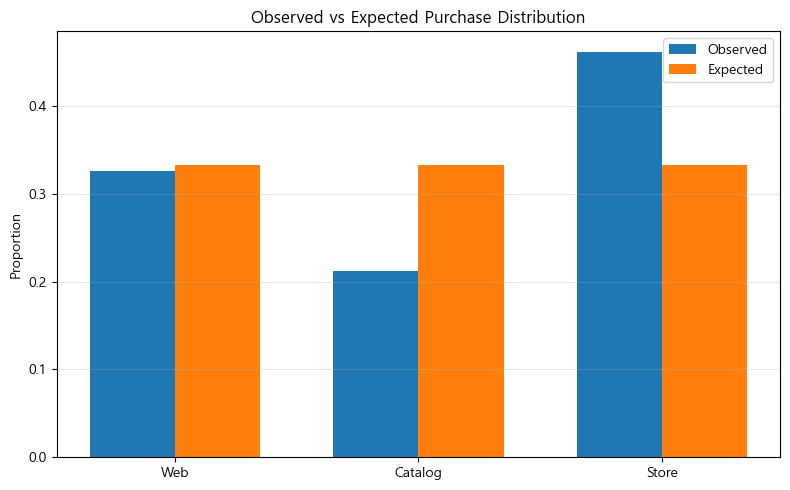

In [53]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프
channel_names = ['Web', 'Catalog', 'Store']
p_obs = observed / total
p_exp = np.array([1/3, 1/3, 1/3])

x = np.arange(len(channel_names))
width = 0.35

plt.figure(figsize=(8,5))

plt.bar(x - width/2, p_obs, width, label='Observed')
plt.bar(x + width/2, p_exp, width, label='Expected')

plt.xticks(x, channel_names)
plt.ylabel("Proportion")
plt.title("Observed vs Expected Purchase Distribution")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [61]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']
data_corr = df_copy[corr_vars]
# TODO 5-1(a): Pearson/Spearman 상관행렬 계산

pearson_corr = data_corr.corr(method='pearson')
spearman_corr = data_corr.corr(method='spearman')
print("=== Pearson Correlation Matrix ===")
display(pearson_corr.round(3))

print("\n=== Spearman Correlation Matrix ===")
display(spearman_corr.round(3))
# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
pairs = [
    ('Income', 'Total_Spending'),
    ('Total_Spending', 'Total_Purchases'),
    ('NumWebVisitsMonth', 'Total_Spending'),
    ('Recency', 'Total_Spending')
]

n = len(df_copy)

print("=== Pearson 상관 유의성 검정 ===")

for x, y in pairs:
    r, p = stats.pearsonr(df_copy[x], df_copy[y])
    print(f"{x} vs {y}")
    print(f"r = {r:.3f}, p = {p:.6g}")

=== Pearson Correlation Matrix ===


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.000,0.199,0.789,0.739,-0.646,0.008
Age,0.199,1.000,0.114,0.173,-0.117,0.019
Total_Spending,0.789,0.114,1.000,0.821,-0.500,0.021
Total_Purchases,0.739,0.173,0.821,1.000,-0.427,0.006
NumWebVisitsMonth,-0.646,-0.117,-0.500,-0.427,1.000,-0.022
Recency,0.008,0.019,0.021,0.006,-0.022,1.000



=== Spearman Correlation Matrix ===


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.000,0.217,0.849,0.777,-0.640,0.010
Age,0.217,1.000,0.158,0.179,-0.129,0.020
Total_Spending,0.849,0.158,1.000,0.908,-0.477,0.020
Total_Purchases,0.777,0.179,0.908,1.000,-0.421,0.012
NumWebVisitsMonth,-0.640,-0.129,-0.477,-0.421,1.000,-0.022
Recency,0.010,0.020,0.020,0.012,-0.022,1.000


=== Pearson 상관 유의성 검정 ===
Income vs Total_Spending
r = 0.789, p = 0
Total_Spending vs Total_Purchases
r = 0.821, p = 0
NumWebVisitsMonth vs Total_Spending
r = -0.500, p = 1.07271e-141
Recency vs Total_Spending
r = 0.021, p = 0.324566


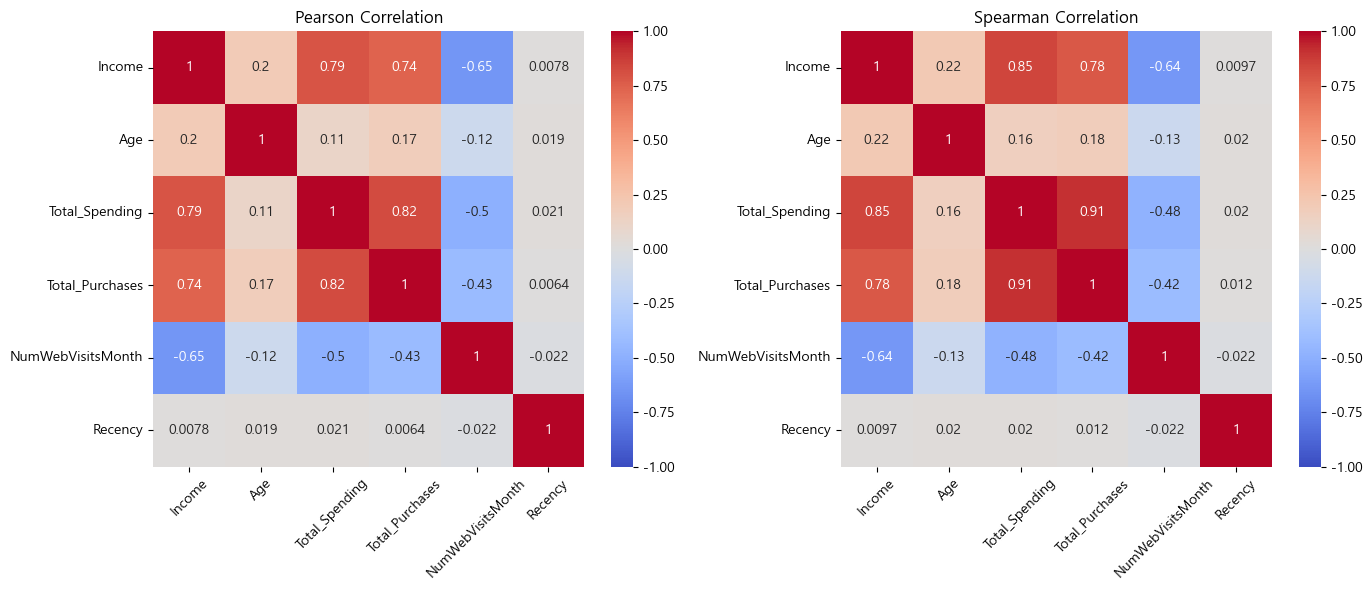

In [64]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)
pearson_corr = data_corr.corr(method='pearson')
spearman_corr = data_corr.corr(method='spearman')
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.heatmap(pearson_corr,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            ax=axes[0])

axes[0].set_title("Pearson Correlation")
axes[0].tick_params(axis='x', rotation=45)
sns.heatmap(spearman_corr,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            ax=axes[1])

axes[1].set_title("Spearman Correlation")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

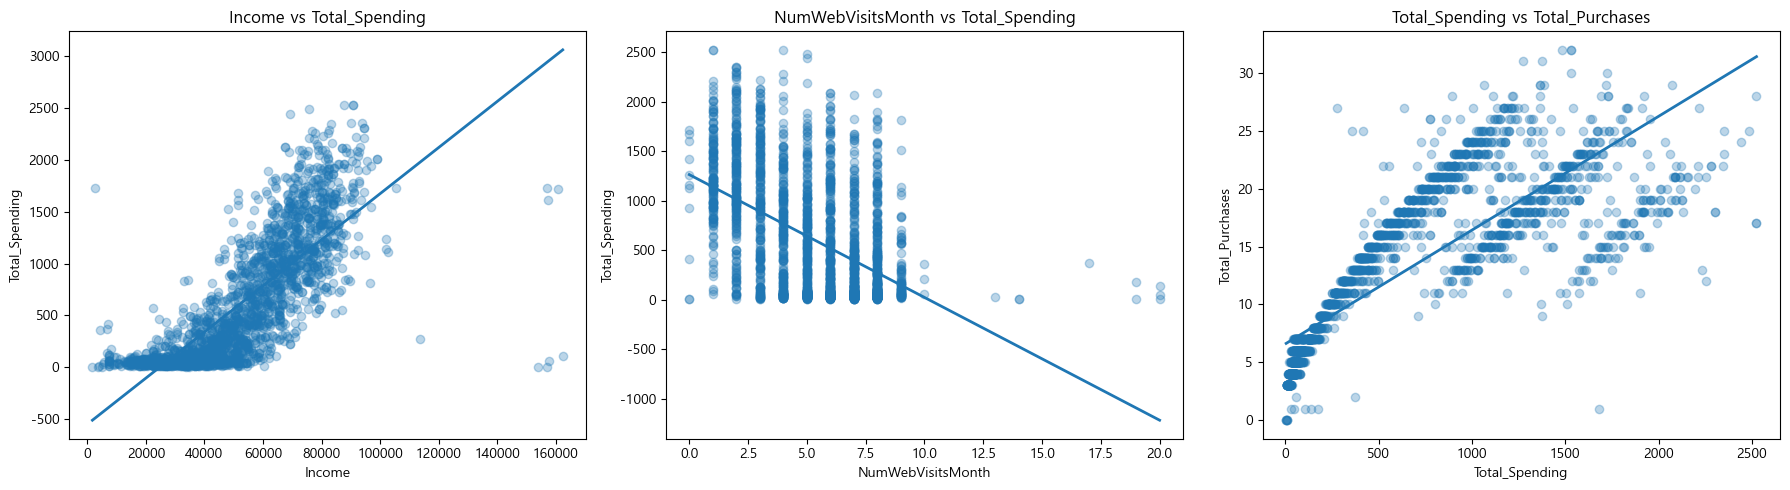

In [65]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요
pairs = [
    ('Income', 'Total_Spending'),
    ('NumWebVisitsMonth', 'Total_Spending'),
    ('Total_Spending', 'Total_Purchases')
]

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for ax, (x_var, y_var) in zip(axes, pairs):
    
    x = df_copy[x_var]
    y = df_copy[y_var]

    ax.scatter(x, y, alpha=0.3)
    slope, intercept = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    
    ax.plot(x_line, y_line, linewidth=2)
    
    ax.set_title(f"{x_var} vs {y_var}")
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)

plt.tight_layout()
plt.show()

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [ ]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df_copy['Prior_Response'] = df_copy[cmp_cols].sum(axis=1)

group_a = df_copy[df_copy['Prior_Response'] == 0]
group_b = df_copy[df_copy['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
p_pool = (conv_a + conv_b) / (n_a + n_b)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))
z = (rate_a - rate_b) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z)))
print(f"p-value = {p_value}")

# TODO 5-2(b): Cohen's h 효과 크기
h = 2 * (np.arcsin(np.sqrt(rate_a)) - np.arcsin(np.sqrt(rate_b)))
print(f"h = {h:.4f}")

# TODO 5-2(c): Wilson 신뢰구간
z = stats.norm.ppf(0.975)

p_a = rate_a
den_a = 1 + z**2 / n_a
center_a = (p_a + z**2/(2*n_a)) / den_a
margin_a = (z * np.sqrt((p_a*(1-p_a) + z**2/(4*n_a)) / n_a)) / den_a

ci_a_low = center_a - margin_a
ci_a_high = center_a + margin_a

p_b = rate_b

den_b = 1 + z**2 / n_b
center_b = (p_b + z**2/(2*n_b)) / den_b
margin_b = (z * np.sqrt((p_b*(1-p_b) + z**2/(4*n_b)) / n_b)) / den_b

ci_b_low = center_b - margin_b
ci_b_high = center_b + margin_b
print(f"Group A: ({ci_a_low:.4f}, {ci_a_high:.4f})")
print(f"Group B: ({ci_b_low:.4f}, {ci_b_high:.4f})")

p-value = 0.00000000000000000000e+00
h = -0.8016
Group A: (0.0704, 0.0960)
Group B: (0.3631, 0.4523)


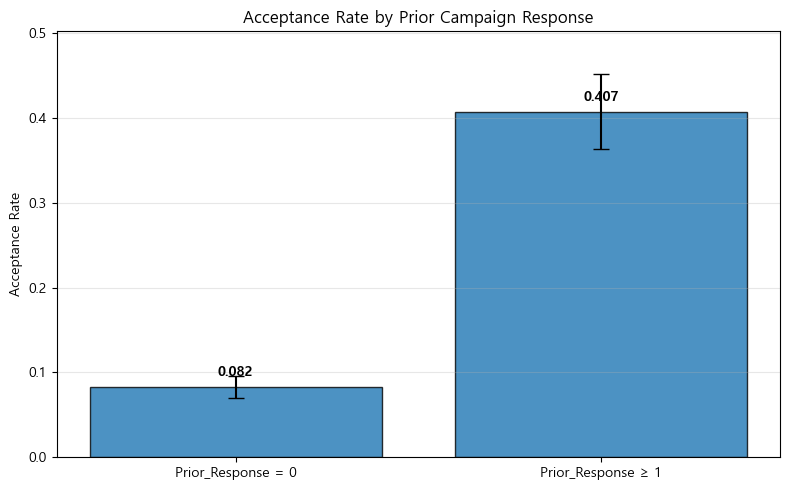

In [72]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)
labels = ['Prior_Response = 0', 'Prior_Response ≥ 1']
rates = np.array([rate_a, rate_b])

lower_err = np.array([rate_a - ci_a_low, rate_b - ci_b_low])
upper_err = np.array([ci_a_high - rate_a, ci_b_high - rate_b])
yerr = np.vstack([lower_err, upper_err])

fig, ax = plt.subplots(figsize=(8,5))

bars = ax.bar(labels, rates, yerr=yerr, capsize=6, alpha=0.8, edgecolor='black')
for bar, r in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2,
            r + 0.01,
            f"{r:.3f}",
            ha='center', va='bottom', fontweight='bold')

ax.set_ylabel("Acceptance Rate")
ax.set_title("Acceptance Rate by Prior Campaign Response")
ax.set_ylim(0, max(ci_a_high, ci_b_high) + 0.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [76]:
baseline_rate = df_copy['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
cohen_h = 2 * (np.arcsin(np.sqrt(target_rate)) - np.arcsin(np.sqrt(baseline_rate)))
print(f"baseline_rate = {baseline_rate:.6f}")
print(f"target_rate = {target_rate:.6f}")
print(f"Cohen's h = {cohen_h:.6f}")

# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)
power_analysis = NormalIndPower()

n_per_group = power_analysis.solve_power(
    effect_size=abs(cohen_h),
    alpha=0.05,
    power=0.80,
    ratio=1.0,
    alternative='larger'
)
print(f"Required n per group = {np.ceil(n_per_group):.0f}")

baseline_rate = 0.149374
target_rate = 0.169374
Cohen's h = 0.054666
Required n per group = 4138


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [81]:
# TODO C-1: 6개 그룹 종합 분석표
group_cols = ['Income_Group', 'Has_Children']

summary = (df_copy
           .groupby(group_cols)
           .agg(
               고객수=('Response', 'size'),
               평균소득=('Income', 'mean'),
               평균소비=('Total_Spending', 'mean'),
               소비중앙값=('Total_Spending', 'median'),
               평균구매수=('Total_Purchases', 'mean'),
               캠페인반응률=('Response', 'mean'),
               평균웹방문=('NumWebVisitsMonth', 'mean')
           )
           .reset_index()
          )
summary['Income_Group'] = pd.Categorical(summary['Income_Group'], categories=order_income, ordered=True)
summary['Has_Children'] = summary['Has_Children'].astype(bool)
summary = summary.sort_values(['Income_Group', 'Has_Children']).reset_index(drop=True)
display(summary)

,Income_Group,Has_Children,고객수,평균소득,평균소비,소비중앙값,평균구매수,캠페인반응률,평균웹방문
0,Low,False,115,24380.243478,145.008696,73.0,6.400000,0.104348,6.930435
1,Low,True,631,29172.879556,86.686212,54.0,5.670365,0.117274,6.901743
2,Mid,False,80,52209.631250,721.237500,653.0,15.362500,0.187500,4.675000
3,Mid,True,665,51466.093985,426.254135,368.0,12.338346,0.090226,5.869173
4,High,False,442,78697.963801,1424.024887,1383.0,19.219457,0.321267,2.366516
5,High,True,303,71841.607261,1033.115512,1005.0,19.178218,0.102310,4.679868


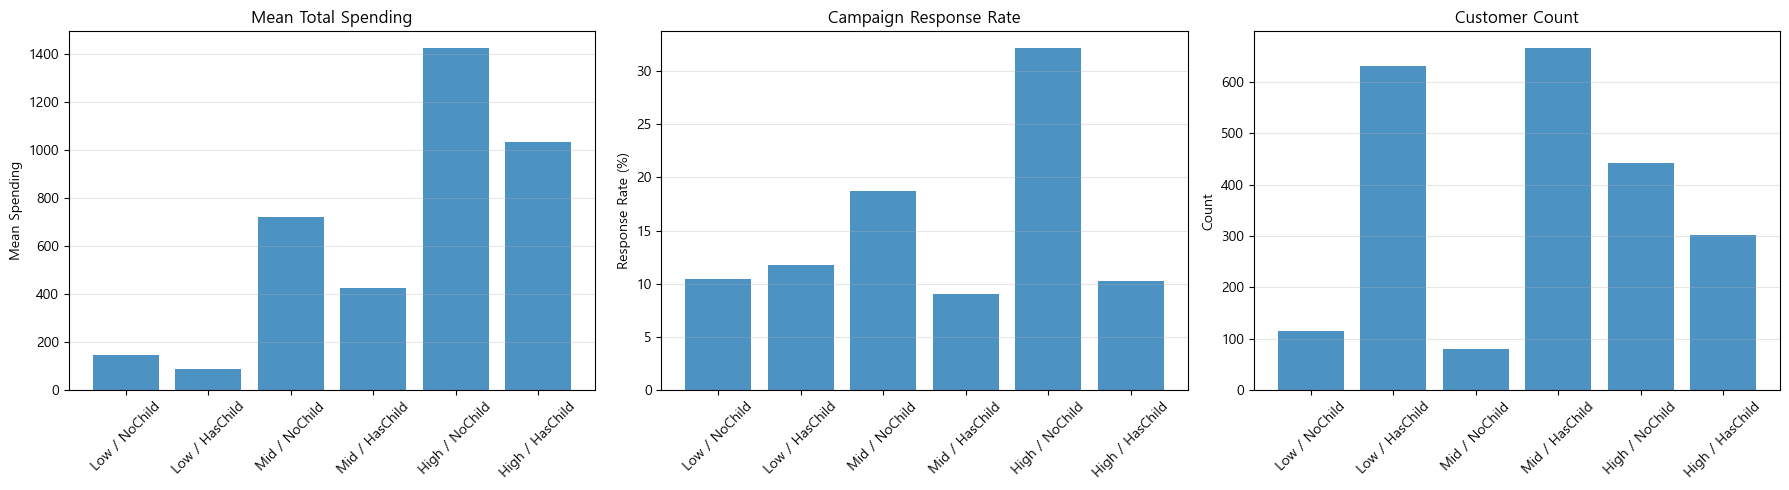

In [80]:
# TODO C-1: 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
summary['그룹라벨'] = summary['Income_Group'].astype(str) + " / " + summary['Has_Children'].map({False:'NoChild', True:'HasChild'})
axes[0].bar(summary['그룹라벨'], summary['평균소비'], alpha=0.8)
axes[0].set_title("Mean Total Spending")
axes[0].set_ylabel("Mean Spending")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(summary['그룹라벨'], summary['캠페인반응률']*100, alpha=0.8)
axes[1].set_title("Campaign Response Rate")
axes[1].set_ylabel("Response Rate (%)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(summary['그룹라벨'], summary['고객수'], alpha=0.8)
axes[2].set_title("Customer Count")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [82]:
# TODO C-2: 비즈니스 제안서 작성
print("High / No Children 최우선 타겟으로 삼는 것이 좋다.")
print("평균소비: 1위, 캠페인반응률: 1위")
print("Mid / No Children 차선 타겟으로 삼는 것이 좋다.")
print("반응률: 높음, 구매수: 높음, 다만 규모가 작아서 차선으로 삼는 것이 좋아보인다.\n")

print("소득 High의 경우는 평균웹 방문이 낮은 것을 볼 수 있으므로, 웹이 아닌 방식을 선택해보고,")
print("소득 Low의 경우는 평균웹 방문이 높은 것을 볼 수 있으므로, 웹방식으로 마케팅하는 것이 좋아보인다.\n")

print("그룹별 종합 분석표를 기반으로 High / No Children 그룹을 우선 타겟팅할 경우, 높은 매출 상승을 기대해볼 수 있음.\n")
print("특히나, 소득과 소비 간 상관(r=0.789)이 강하게 나타났으므로,")
print("고소득군 중심 전략은 구조적으로 매출 증가와 연결될 가능성이 높음.")
print("과거 수락 경험 분석에서 Cohen's h가 약 0.80 수준으로 큰 효과크기를 보였음.")
print("이는 과거 반응 고객을 재타겟팅할 경우 전환율이 유의하게 개선될 가능성이 높다는 의미임.\n")

print("상관분석 및 집단 비교 중심으로 수행되었으며,")
print("변수 간 인과관계를 직접적으로 증명하지는 못함.")
print("비용 정보가 없어 실제 수익을 정량적으로 계산하지 못함")

High / No Children 최우선 타겟으로 삼는 것이 좋다.
평균소비: 1위, 캠페인반응률: 1위
Mid / No Children 차선 타겟으로 삼는 것이 좋다.
반응률: 높음, 구매수: 높음, 다만 규모가 작아서 차선으로 삼는 것이 좋아보인다.

소득 High의 경우는 평균웹 방문이 낮은 것을 볼 수 있으므로, 웹이 아닌 방식을 선택해보고,
소득 Low의 경우는 평균웹 방문이 높은 것을 볼 수 있으므로, 웹방식으로 마케팅하는 것이 좋아보인다.

그룹별 종합 분석표를 기반으로 High / No Children 그룹을 우선 타겟팅할 경우, 높은 매출 상승을 기대해볼 수 있음.

특히나, 소득과 소비 간 상관(r=0.789)이 강하게 나타났으므로,
고소득군 중심 전략은 구조적으로 매출 증가와 연결될 가능성이 높음.
과거 수락 경험 분석에서 Cohen's h가 약 0.80 수준으로 큰 효과크기를 보였음.
이는 과거 반응 고객을 재타겟팅할 경우 전환율이 유의하게 개선될 가능성이 높다는 의미임.

상관분석 및 집단 비교 중심으로 수행되었으며,
변수 간 인과관계를 직접적으로 증명하지는 못함.
비용 정보가 없어 실제 수익을 정량적으로 계산하지 못함


---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛